In [26]:
import numpy as np
from skimage import io
from os import listdir
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle

In [27]:
#divide by 20 for electron-photon conversion
im_stack_plain = np.load('np_data/DD_F.npy')/20
energies_plain = np.load('np_data/DD_F_Energies.npy')
im_stack = np.load('np_data/DD_F_Migdal.npy')/20
energies = np.load('np_data/DD_F_Migdal_Energies.npy')
e_stack = np.load('np_data/Fe55.npy')/20

isp_sum = np.sum(im_stack_plain,axis=(1,2))
is_sum = np.sum(im_stack,axis=(1,2))

im_stack_plain = im_stack_plain[isp_sum>100]
im_stack = im_stack[is_sum>100]
energies_plain= energies_plain[isp_sum>100]
energies= energies[is_sum>100]

clip = False

In [28]:
np.shape(im_stack_plain)

(9815, 150, 150)

In [29]:
np.shape(im_stack)

(9789, 150, 150)

In [30]:
np.shape(im_stack_plain[0])

(150, 150)

In [31]:
if clip:
    im_stack_plain = im_stack_plain[energies_plain > 50]
    energies_plain = energies_plain[energies_plain > 50]
    im_stack = im_stack[energies > 50]
    energies = energies[energies > 50]

## Saving Noiseless Images

plain: 17, 24\
mig: 2315, 5601

In [32]:
# np.save('Figure_Data/fig6_plain1', im_stack_plain[17])
# np.save('Figure_Data/fig6_plain2', im_stack_plain[24])
# np.save('Figure_Data/fig6_mig1', im_stack[2315])
# np.save('Figure_Data/fig6_mig2', im_stack[5601])

In [33]:
# n = 24
# plt.imshow(im_stack_plain[n])
# print(energies_plain[n])

In [34]:
# n = 2315
# plt.imshow(im_stack[n])
# print(energies[n])

In [35]:
noise = np.stack([io.imread("bg/"+im) for im in listdir('bg/')],axis=0)

noise = noise[:,::2,::2] + noise[:,1::2,::2] + noise[:,::2,1::2] + noise[:,1::2,1::2]

In [36]:
noise_i = np.random.randint(0,1000,len(im_stack_plain))
noise_x = np.random.randint(0,426,len(im_stack_plain))
noise_y = np.random.randint(0,426,len(im_stack_plain))

noise_train = np.stack([noise[noise_i[i], noise_x[i]:noise_x[i]+150, noise_y[i]:noise_y[i]+150] for i in range(len(noise_i))],axis=0)
im_stack_plain = im_stack_plain + noise_train

In [12]:
noise_i = np.random.randint(0,1000,len(im_stack))
noise_x = np.random.randint(0,426,len(im_stack))
noise_y = np.random.randint(0,426,len(im_stack))

noise_train = np.stack([noise[noise_i[i], noise_x[i]:noise_x[i]+150, noise_y[i]:noise_y[i]+150] for i in range(len(noise_i))],axis=0)
im_stack = im_stack + noise_train

In [13]:
noise_i = np.random.randint(0,1000,len(e_stack))
noise_x = np.random.randint(0,426,len(e_stack))
noise_y = np.random.randint(0,426,len(e_stack))

noise_train = np.stack([noise[noise_i[i], noise_x[i]:noise_x[i]+150, noise_y[i]:noise_y[i]+150] for i in range(len(noise_i))],axis=0)
e_stack = e_stack + noise_train

# Producing Energy vs. Frequency Plots

In [21]:
labels = np.concatenate([np.zeros_like(energies),np.ones_like(energies_plain)])
data = np.concatenate([im_stack,im_stack_plain])

In [22]:
train_data_noise, test_data_noise, train_labels, test_labels = \
train_test_split(data, labels, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
#         Dropout(0.1),
        Dense(30),
        LeakyReLU(),
#         Dropout(0.1),
        Dense(15),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

2022-09-01 15:01:09.794779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-01 15:01:09.797743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-01 15:01:10.285372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 15:01:10.285664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:03.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-09-01 15:01:10.285702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-01 15:01:10.287877: I tensorflow/stream_executor/platform/default/ds

In [28]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(train_data_noise,axis=-1), train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(test_data_noise,axis=-1), test_labels))
train_dataset_noise.element_spec

(TensorSpec(shape=(150, 150, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [29]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=8)

model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=50, validation_data=(test_dataset_noise),callbacks=[callback])

Epoch 1/50
314/314 [==============================] - 6s 17ms/step - loss: 235.2039 - accuracy: 0.5711 - val_loss: 3.0112 - val_accuracy: 0.6057
Epoch 2/50
314/314 [==============================] - 5s 16ms/step - loss: 2.8783 - accuracy: 0.6146 - val_loss: 1.7382 - val_accuracy: 0.6947
Epoch 3/50
314/314 [==============================] - 5s 16ms/step - loss: 8.3478 - accuracy: 0.6268 - val_loss: 1.5232 - val_accuracy: 0.6720
Epoch 4/50
314/314 [==============================] - 5s 16ms/step - loss: 1.7985 - accuracy: 0.6531 - val_loss: 1.8391 - val_accuracy: 0.6728
Epoch 5/50
314/314 [==============================] - 5s 16ms/step - loss: 3.5080 - accuracy: 0.6419 - val_loss: 8.0380 - val_accuracy: 0.5185
Epoch 6/50
314/314 [==============================] - 5s 16ms/step - loss: 16.1851 - accuracy: 0.5876 - val_loss: 0.8380 - val_accuracy: 0.7047
Epoch 7/50
314/314 [==============================] - 5s 16ms/step - loss: 0.8414 - accuracy: 0.6960 - val_loss: 1.2284 - val_accuracy: 0.5

In [37]:
right = []
wrong = []

for i in range(len(im_stack)):
    test=im_stack[i].reshape(1,150,150,1)
    correct = not round(model(test)[0][0].numpy())
    
    if correct:
        right.append(energies[i])
    else:
        wrong.append(energies[i])

In [38]:
len(right)/(len(right)+len(wrong))

0.7232608029420778

(array([55., 60., 65., 70., 75., 80., 85., 90.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

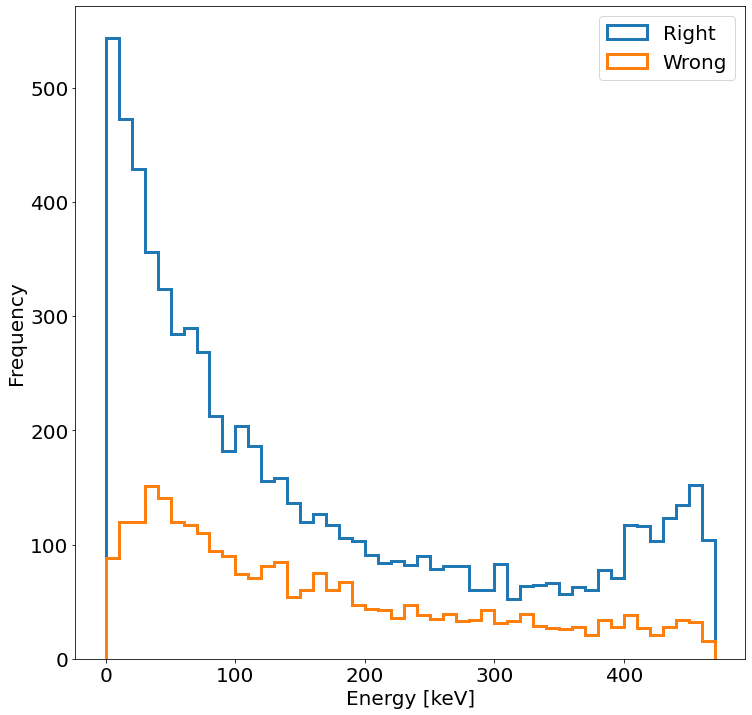

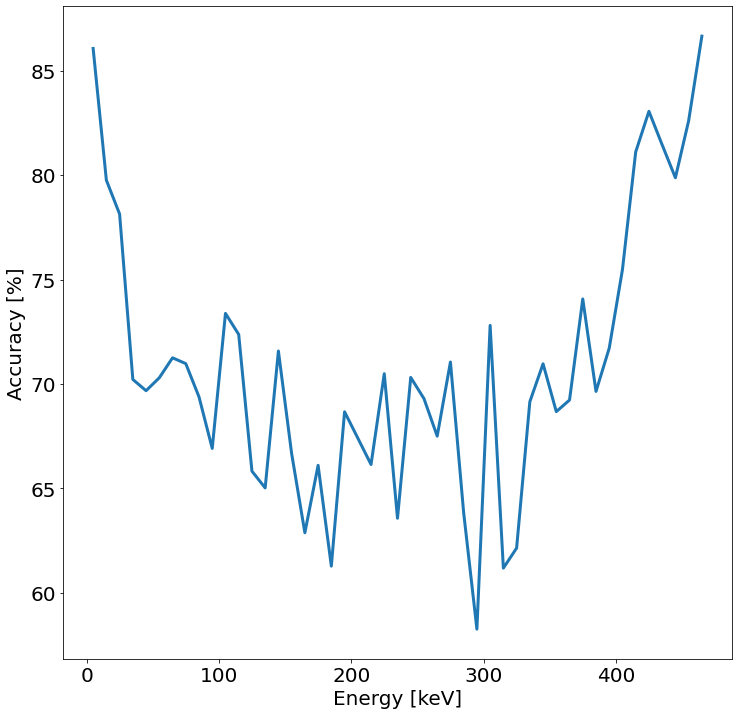

In [39]:
plt.figure(figsize=(12,12))
n_r,bins_r,patch = plt.hist(right,bins=np.arange(0,471,10),label='Right',histtype='step',lw=3)
n_w,bins_w,patch = plt.hist(wrong,bins=np.arange(0,471,10),label='Wrong',histtype='step',lw=3)
plt.legend(fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.figure(figsize=(12,12))
plt.plot((bins_r[:-1]+bins_r[1:])/2,n_r/(n_w+n_r)*100, lw=3)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [40]:
np.save('Figure_Data/fig9_right_no_e', right)
np.save('Figure_Data/fig9_wrong_no_e', wrong)

### With Electrons Plot

In [42]:
labels = np.concatenate([np.zeros_like(energies),np.ones_like(energies_plain),np.ones(len(e_stack))])
data = np.concatenate([im_stack,im_stack_plain,e_stack])

shuffle_index = np.arange(len(labels))
np.random.shuffle(shuffle_index)

labels = labels[shuffle_index]
data = data[shuffle_index]

In [43]:
train_data_noise, test_data_noise, train_labels, test_labels = \
train_test_split(data, labels, test_size=0.2, random_state=42)

In [44]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(train_data_noise,axis=-1), train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(test_data_noise,axis=-1), test_labels))
train_dataset_noise.element_spec

(TensorSpec(shape=(150, 150, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [45]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=8)

model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=50, validation_data=(test_dataset_noise),callbacks=[callback])

Epoch 1/50
473/473 [==============================] - 8s 16ms/step - loss: 148.9907 - accuracy: 0.6364 - val_loss: 3.9824 - val_accuracy: 0.7403
Epoch 2/50
473/473 [==============================] - 8s 16ms/step - loss: 8.8889 - accuracy: 0.7061 - val_loss: 1.6115 - val_accuracy: 0.7476
Epoch 3/50
473/473 [==============================] - 8s 16ms/step - loss: 1.8004 - accuracy: 0.7639 - val_loss: 0.9810 - val_accuracy: 0.8132
Epoch 4/50
473/473 [==============================] - 8s 16ms/step - loss: 1.0976 - accuracy: 0.7933 - val_loss: 1.0090 - val_accuracy: 0.7895
Epoch 5/50
473/473 [==============================] - 8s 16ms/step - loss: 1.5523 - accuracy: 0.7851 - val_loss: 32.2627 - val_accuracy: 0.6702
Epoch 6/50
473/473 [==============================] - 8s 16ms/step - loss: 3.3690 - accuracy: 0.7207 - val_loss: 0.9214 - val_accuracy: 0.6900
Epoch 7/50
473/473 [==============================] - 8s 16ms/step - loss: 0.6353 - accuracy: 0.7769 - val_loss: 0.7000 - val_accuracy: 0.7

In [47]:
right = []
wrong = []

for i in range(len(im_stack)):
    test=im_stack[i].reshape(1,150,150,1)
    correct = not round(model(test)[0][0].numpy())
    
    if correct:
        right.append(energies[i])
    else:
        wrong.append(energies[i])

In [48]:
len(right)/(len(right)+len(wrong))

0.723669424864644

(array([40., 50., 60., 70., 80., 90.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

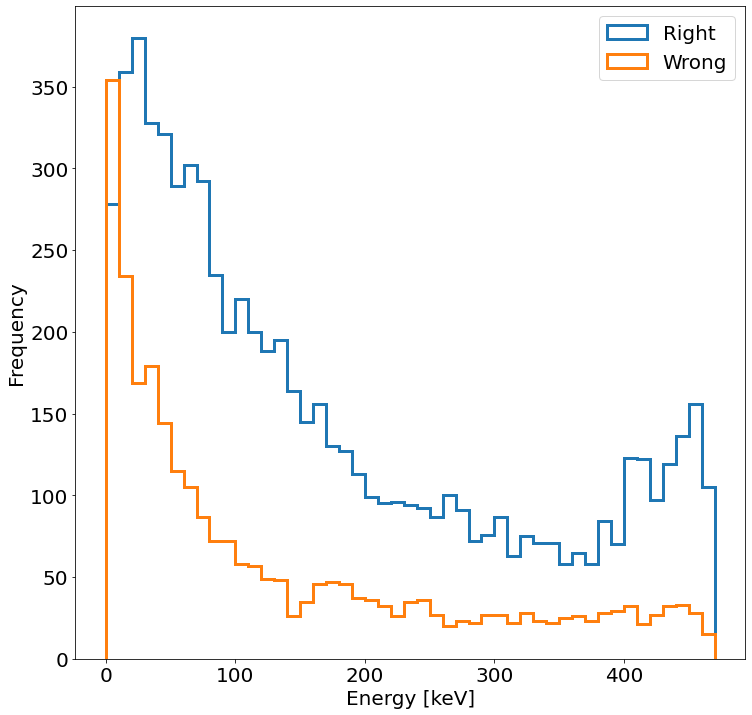

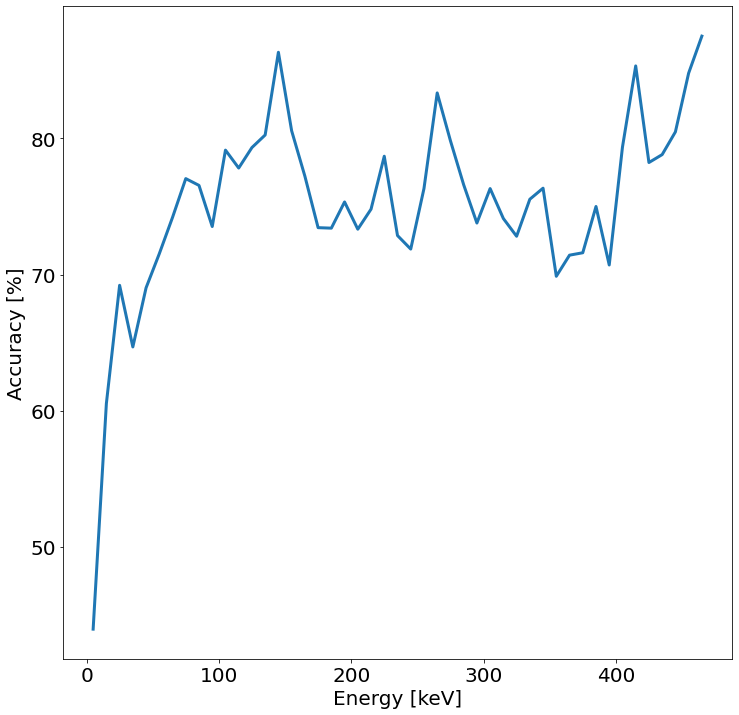

In [49]:
plt.figure(figsize=(12,12))
n_r,bins_r,patch = plt.hist(right,bins=np.arange(0,471,10),label='Right',histtype='step',lw=3)
n_w,bins_w,patch = plt.hist(wrong,bins=np.arange(0,471,10),label='Wrong',histtype='step',lw=3)
plt.legend(fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.figure(figsize=(12,12))
plt.plot((bins_r[:-1]+bins_r[1:])/2,n_r/(n_w+n_r)*100, lw=3)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [50]:
np.save('Figure_Data/fig9_right_e', right)
np.save('Figure_Data/fig9_wrong_e', wrong)

# Continuation of old document

In [183]:
energy_labels = np.concatenate([energies,energies_plain,5.9*np.ones(len(e_stack))])
labels = np.concatenate([np.zeros_like(energies),np.ones_like(energies_plain),np.ones(len(e_stack))])
data = np.concatenate([im_stack,im_stack_plain,e_stack])

shuffle_index = np.arange(len(labels))
np.random.shuffle(shuffle_index)

energy_labels = energy_labels[shuffle_index]
labels = labels[shuffle_index]
data = data[shuffle_index]

In [184]:
train_data_noise, test_data_noise, train_labels, test_labels, train_elabs, test_elabs = \
train_test_split(data, labels, energy_labels, test_size=0.2, random_state=42)

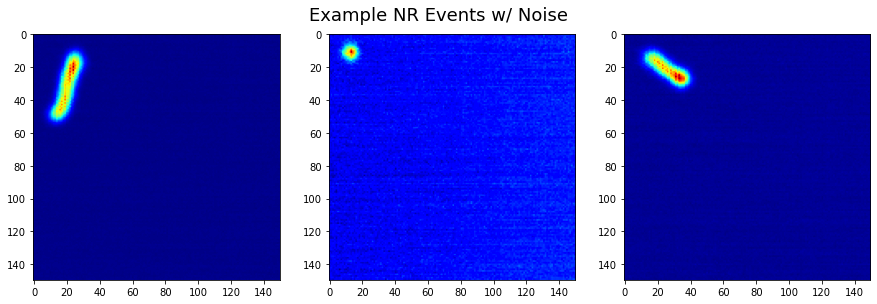

In [185]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Example NR Events w/ Noise',fontsize=18)
fig.subplots_adjust(top=1)
ax1.imshow(im_stack_plain[1000],cmap='jet')
ax2.imshow(im_stack_plain[10],cmap='jet')
ax3.imshow(im_stack_plain[1505],cmap='jet');


# plt.figure(figsize=(12,12))
# plt.imshow(im_stack_plain[i])
# print(im_stack_plain[i]);

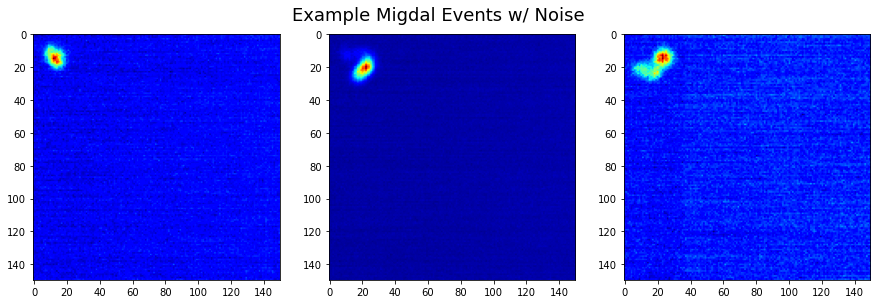

In [186]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Example Migdal Events w/ Noise',fontsize=18)
fig.subplots_adjust(top=1)
ax1.imshow(im_stack[3],cmap='jet')
ax2.imshow(im_stack[8000],cmap='jet')
ax3.imshow(im_stack[1012],cmap='jet');



# plt.figure(figsize=(12,12))
# plt.imshow(im_stack_plain[i])
# print(im_stack_plain[i]);

# Saving Noisy Images for Report

Plain: 6
Mig: 2, 3000
Electron: 11

In [ ]:
np.save('Figure_Data/fig7_plain1', im_stack_plain[6])
np.save('Figure_Data/fig7_mig1', im_stack[2])
np.save('Figure_Data/fig7_mig2', im_stack[3000])
np.save('Figure_Data/fig7_electron1', e_stack[11])

In [25]:
np.save('Figure_Data/fig7_plain2', im_stack_plain[400])
np.save('Figure_Data/fig7_mig3', im_stack[6])

263.315


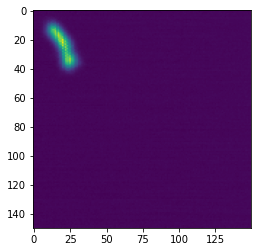

In [24]:
n = 400
plt.imshow(im_stack_plain[n])
print(energies_plain[n])

1.11


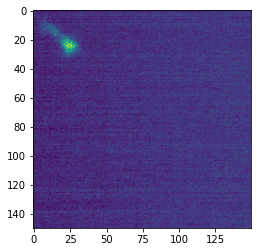

In [22]:
n = 6
plt.imshow(im_stack[n])
print(energies[n])

energy is 5.9keV


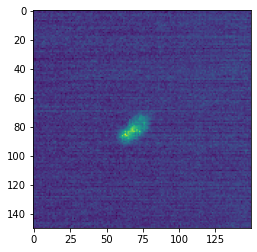

In [190]:
n = 11
plt.imshow(e_stack[n])
print('energy is 5.9keV')

In [ ]:
# i=1

# plt.figure(figsize=(12,12))
# plt.imshow(im_stack_plain[i])
# print(im_stack_plain[i]);

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.15 ... 0.   0.   0.  ]
 [0.   0.   0.7  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


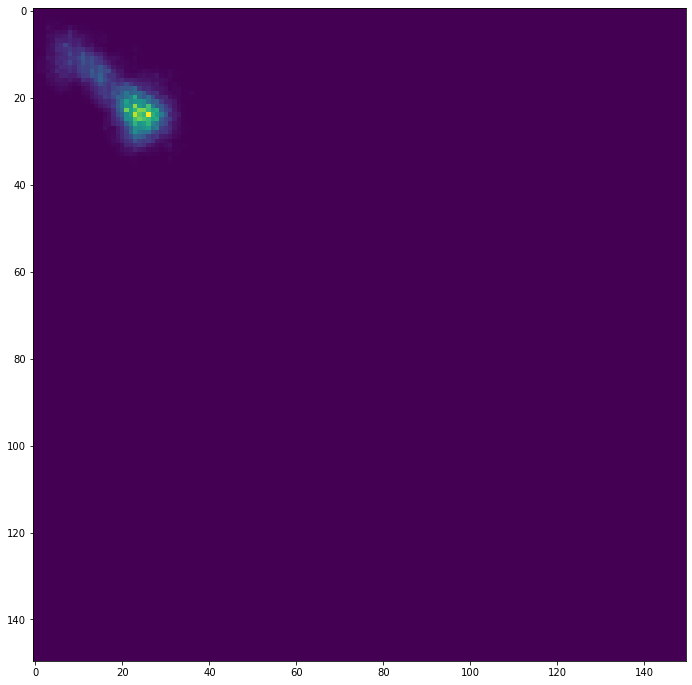

In [105]:
i=6

plt.figure(figsize=(12,12))
plt.imshow(im_stack[i])
print(im_stack[i]);

5.9


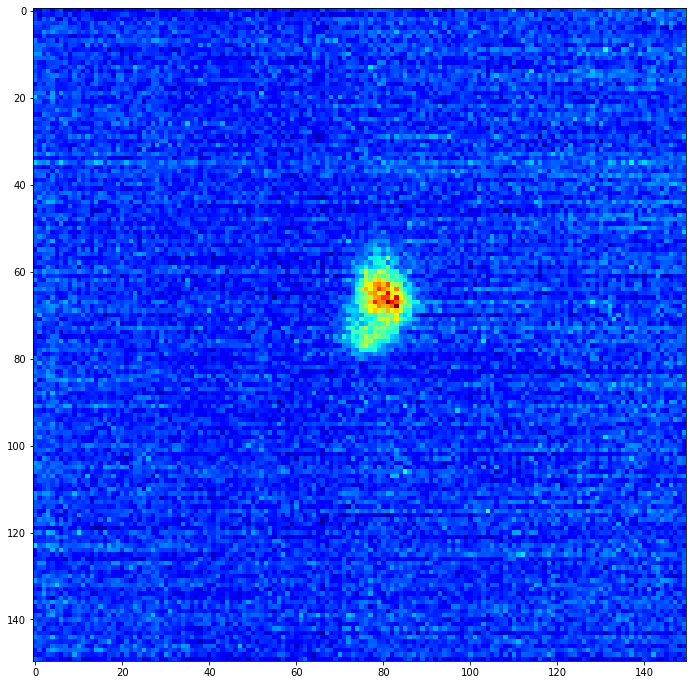

In [200]:
i=3

plt.figure(figsize=(12,12))
plt.imshow(test_data_noise[i],cmap='jet')
print(test_elabs[i]);

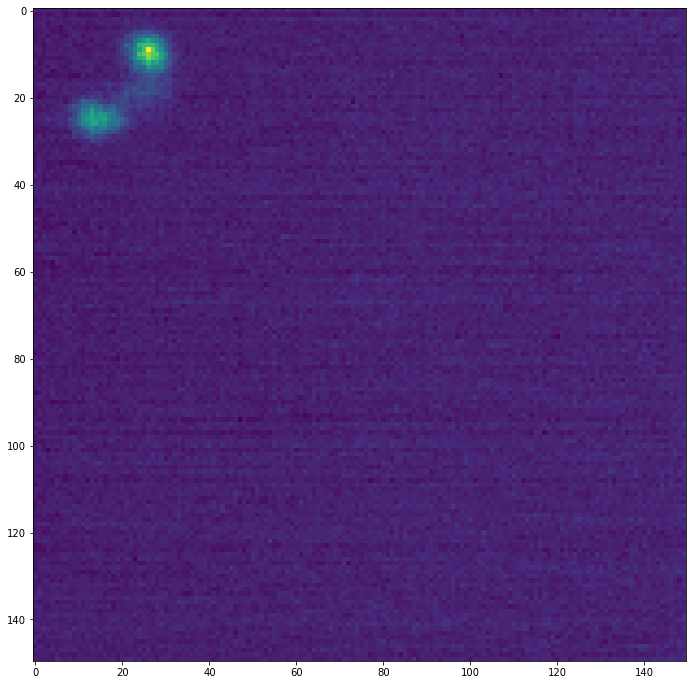

In [202]:
plt.figure(figsize=(12,12))
plt.imshow(train_data_noise[1]);

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
        Flatten(),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

2022-06-15 10:56:42.870364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 10:56:42.885859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vols/software/cuda/latest/CentOS7/lib64
2022-06-15 10:56:42.885898: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-15 10:56:42.886561: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary i

In [5]:
model.summary()

Model: "mig_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 10)      100       
                                                                 
 flatten (Flatten)           (None, 225000)            0         
                                                                 
 dense (Dense)               (None, 30)                6750030   
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 6,750,161
Trainable params: 6,750,161
Non-trainable params: 0
_________________________________________________________________


In [82]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labs in train_dataset.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [83]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [10]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='MSE',metrics=['accuracy'])
model.fit(train_dataset, epochs=15, validation_data=(test_dataset))

Epoch 1/15
314/314 [==============================] - 14s 44ms/step - loss: 0.5002 - accuracy: 0.5042 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 2/15
314/314 [==============================] - 13s 41ms/step - loss: 0.5007 - accuracy: 0.4993 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 3/15
314/314 [==============================] - 13s 41ms/step - loss: 0.5007 - accuracy: 0.4993 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 4/15
314/314 [==============================] - 13s 41ms/step - loss: 0.5007 - accuracy: 0.4993 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 5/15
314/314 [==============================] - 13s 40ms/step - loss: 0.5007 - accuracy: 0.4993 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 6/15
314/314 [==============================] - 13s 41ms/step - loss: 0.5007 - accuracy: 0.4993 - val_loss: 0.4934 - val_accuracy: 0.5066
Epoch 7/15
314/314 [==============================] - 13s 40ms/step - loss: 0.5006 - accuracy: 0.4994 - val_loss: 0.4934 - val_accuracy:

## Testing More

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [ ]:
model.summary()

In [ ]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='MSE',metrics=['accuracy'])
model.fit(train_dataset, epochs=15, validation_data=(test_dataset))

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
        MaxPooling2D(),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [52]:
model.summary()

Model: "mig_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 150, 10)      100       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 10)       0         
 2D)                                                             
                                                                 
 flatten_13 (Flatten)        (None, 56250)             0         
                                                                 
 dense_27 (Dense)            (None, 100)               5625100   
                                                                 
 dense_28 (Dense)            (None, 30)                3030      
                                                                 
 dense_29 (Dense)            (None, 1)                 31        
                                                         

In [55]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='MSE',metrics=['accuracy'])
model.fit(train_dataset, epochs=150, validation_data=(test_dataset))

Epoch 1/150
314/314 [==============================] - 15s 48ms/step - loss: 0.3082 - accuracy: 0.7005 - val_loss: 0.1989 - val_accuracy: 0.8011
Epoch 2/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1944 - accuracy: 0.8056 - val_loss: 0.1923 - val_accuracy: 0.8078
Epoch 3/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1882 - accuracy: 0.8118 - val_loss: 0.1900 - val_accuracy: 0.8100
Epoch 4/150
314/314 [==============================] - 15s 46ms/step - loss: 0.1748 - accuracy: 0.8252 - val_loss: 0.1708 - val_accuracy: 0.8292
Epoch 5/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1737 - accuracy: 0.8263 - val_loss: 0.1713 - val_accuracy: 0.8287
Epoch 6/150
314/314 [==============================] - 15s 46ms/step - loss: 0.1738 - accuracy: 0.8262 - val_loss: 0.1713 - val_accuracy: 0.8287
Epoch 7/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1740 - accuracy: 0.8260 - val_loss: 0.1713 - val_ac

314/314 [==============================] - 14s 46ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 114/150
314/314 [==============================] - 14s 46ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 115/150
314/314 [==============================] - 15s 46ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 116/150
314/314 [==============================] - 15s 46ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 117/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 118/150
314/314 [==============================] - 15s 46ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_accuracy: 0.8297
Epoch 119/150
314/314 [==============================] - 15s 47ms/step - loss: 0.1701 - accuracy: 0.8299 - val_loss: 0.1703 - val_ac

# Grid Searching

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [9]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labs in train_dataset.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [10]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier

def mig_model():
    
    model = Sequential()
    model.add(Conv2D(5, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# def mig_model():
#     model = Sequential([
#         Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
#         Flatten(),
#         Dense(30, activation='relu'),
#         Dense(1, activation='sigmoid'),
#     ], name='mig_model')
    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     return mig_model

In [11]:
seed = 5
np.random.seed(seed)

In [48]:
model = KerasClassifier(build_fn=mig_model, verbose=0)

/tmp/ipykernel_29177/2922171102.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=mig_model, verbose=0)


In [12]:
batch_size = [50, 100]
epochs = [1, 2, 3]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=None)
grid_result = grid.fit(train_data, train_labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x7eff2c492be0> does not.

In [53]:
grid_result.cv_results_

{'mean_fit_time': array([ 91.55508103, 450.17605081,  91.02172327, 445.41954937]),
 'std_fit_time': array([7.92623596, 8.80345121, 0.82269938, 0.94957927]),
 'mean_score_time': array([1.11462665, 1.12487106, 1.10233617, 1.05969882]),
 'std_score_time': array([0.04304414, 0.01579037, 0.15343419, 0.01581114]),
 'param_batch_size': masked_array(data=[50, 50, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[10, 50, 10, 50],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'batch_size': 50, 'epochs': 10},
  {'batch_size': 50, 'epochs': 50},
  {'batch_size': 100, 'epochs': 10},
  {'batch_size': 100, 'epochs': 50}],
 'split0_test_score': array([0.84225619, 0.48725304, 0.84161884, 0.84161884]),
 'split1_test_score': array([0.83779478, 0.49617592, 0.83588272, 0.83524537]),
 'split2_test_score': array([0.50509876, 0.50254941, 0.492989

# Noise on test set

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout


def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
        Flatten(),
        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [43]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((test_data_noise, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labs in train_dataset.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [44]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)

In [46]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset, epochs=5, validation_data=(test_dataset_noise))

Epoch 1/5
314/314 [==============================] - 14s 42ms/step - loss: 2.3565 - accuracy: 0.8163 - val_loss: 3938.7080 - val_accuracy: 0.4985
Epoch 2/5
314/314 [==============================] - 13s 42ms/step - loss: 0.3392 - accuracy: 0.8638 - val_loss: 5934.3496 - val_accuracy: 0.4985
Epoch 3/5
314/314 [==============================] - 13s 41ms/step - loss: 0.3360 - accuracy: 0.8668 - val_loss: 15730.8271 - val_accuracy: 0.4985
Epoch 4/5
314/314 [==============================] - 13s 42ms/step - loss: 0.2931 - accuracy: 0.8653 - val_loss: 10855.4814 - val_accuracy: 0.4985
Epoch 5/5
314/314 [==============================] - 13s 42ms/step - loss: 0.2674 - accuracy: 0.8693 - val_loss: 13589.8799 - val_accuracy: 0.4985


# Noise on train and test

## Trying for maximum accuracy

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
#         Dropout(0.1),
        Dense(30),
        LeakyReLU(),
#         Dropout(0.1),
        Dense(15),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [159]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((train_data_noise, train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((test_data_noise, test_labels))
migdal_dataset_noise = tf.data.Dataset.from_tensor_slices((im_stack, np.zeros_like(energies)))
train_dataset_noise.element_spec

#printing relevant properties
for inputs, labs in train_dataset_noise.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [160]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)
migdal_dataset_noise = migdal_dataset_noise.batch(batch_size)

In [161]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5)

model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=25, validation_data=(test_dataset_noise),callbacks=[callback])

Epoch 1/25
473/473 [==============================] - 37s 77ms/step - loss: 33.8652 - accuracy: 0.6767 - val_loss: 1.8907 - val_accuracy: 0.7922
Epoch 2/25
473/473 [==============================] - 36s 76ms/step - loss: 2.4823 - accuracy: 0.7451 - val_loss: 2.3359 - val_accuracy: 0.7974
Epoch 3/25
473/473 [==============================] - 37s 77ms/step - loss: 75.7676 - accuracy: 0.6992 - val_loss: 3.4230 - val_accuracy: 0.7444
Epoch 4/25
473/473 [==============================] - 36s 77ms/step - loss: 3.4234 - accuracy: 0.6862 - val_loss: 0.9361 - val_accuracy: 0.7600
Epoch 5/25
473/473 [==============================] - 36s 77ms/step - loss: 1.3377 - accuracy: 0.7341 - val_loss: 0.7869 - val_accuracy: 0.7929
Epoch 6/25
473/473 [==============================] - 36s 77ms/step - loss: 1.0682 - accuracy: 0.7481 - val_loss: 1.1458 - val_accuracy: 0.6565
Epoch 7/25
473/473 [==============================] - 37s 77ms/step - loss: 0.8313 - accuracy: 0.7690 - val_loss: 1.1319 - val_accurac

In [162]:
right = []
wrong = []

for i in range(len(im_stack)):
    test=im_stack[i].reshape(1,150,150,1)
    correct = not round(model(test)[0][0].numpy())
    
    if correct:
        right.append(energies[i])
    else:
        wrong.append(energies[i]) 

In [163]:
len(right)/(len(right)+len(wrong))

0.5267136581877617

In [165]:
right = []
wrong = []

for i in range(len(im_stack_plain)):
    test=im_stack_plain[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy())
    
    if correct:
        right.append(1)
    else:
        wrong.append(2)
        
for i in range(len(e_stack)):
    test=e_stack[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy())
    
    if correct:
        right.append(1)
    else:
        wrong.append(2)

In [166]:
len(right)/(len(right)+len(wrong))

0.9441909975669099

## Validating on Migdal only

In [139]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

# def mig_model():
#     mig_model = Sequential([
#         Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
#         MaxPooling2D(),
#         Conv2D(10, kernel_size=(3,3), activation='relu', padding='same'),
#         MaxPooling2D(),
#         Flatten(),
#         Dense(100, activation='relu'),
#         Dropout(0.1),
#         Dense(30, activation='relu'),
#         Dropout(0.1),
#         Dense(1, activation='sigmoid'),
#     ], name='mig_model')
#     return mig_model

# model = mig_model()

In [149]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
#         Dropout(0.1),
        Dense(30),
        LeakyReLU(),
#         Dropout(0.1),
        Dense(15),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [150]:
np.shape(train_data_noise)

(23613, 150, 150)

In [151]:
np.shape(im_stack)

(9789, 150, 150)

In [152]:
np.shape(energies)

(9789,)

In [153]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((train_data_noise, train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((test_data_noise, test_labels))
migdal_dataset_noise = tf.data.Dataset.from_tensor_slices((im_stack, np.zeros_like(energies)))
train_dataset_noise.element_spec

#printing relevant properties
for inputs, labs in train_dataset_noise.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [154]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)
migdal_dataset_noise = migdal_dataset_noise.batch(batch_size)

In [156]:
# model = mig_model()

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
# model.fit(train_dataset_noise, epochs=5, validation_data=(migdal_dataset_noise))

In [157]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5)

model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=25, validation_data=(migdal_dataset_noise),callbacks=[callback])

In [250]:
# right = []
# wrong = []

# for i in range(len(test_labels)):
#     test=test_data_noise[i].reshape(1,150,150,1)
#     correct = test_labels[i] == round(model.predict(test)[0][0])
    
#     if correct:
#         right.append(test_elabs[i])
#     else:
#         wrong.append(test_elabs[i])

KeyboardInterrupt: 

In [283]:
right = []
wrong = []

for i in range(len(im_stack)):
    test=im_stack[i].reshape(1,150,150,1)
    correct = not round(model(test)[0][0].numpy())
    
    if correct:
        right.append(energies[i])
    else:
        wrong.append(energies[i])

In [284]:
len(right)/(len(right)+len(wrong))

0.9608744509142916

(array([ 75.,  80.,  85.,  90.,  95., 100., 105.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

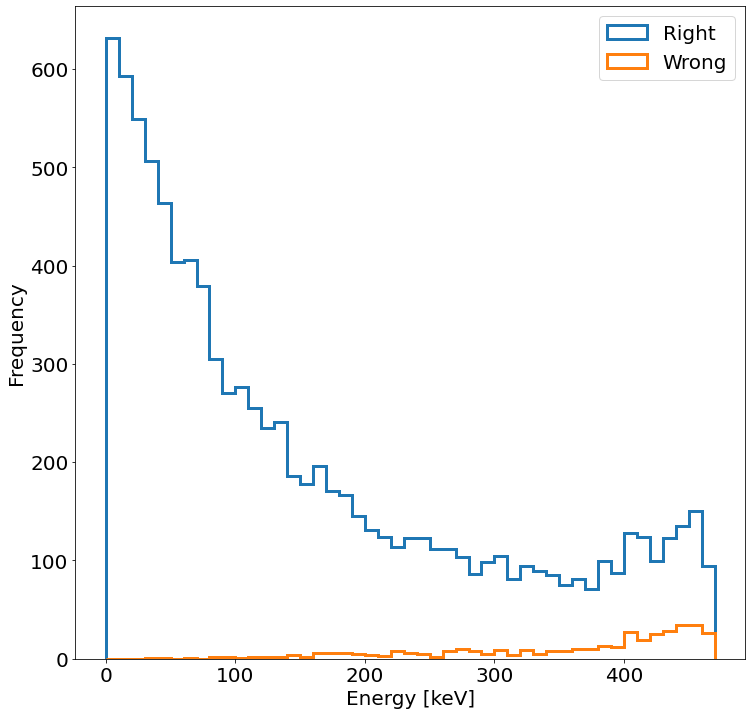

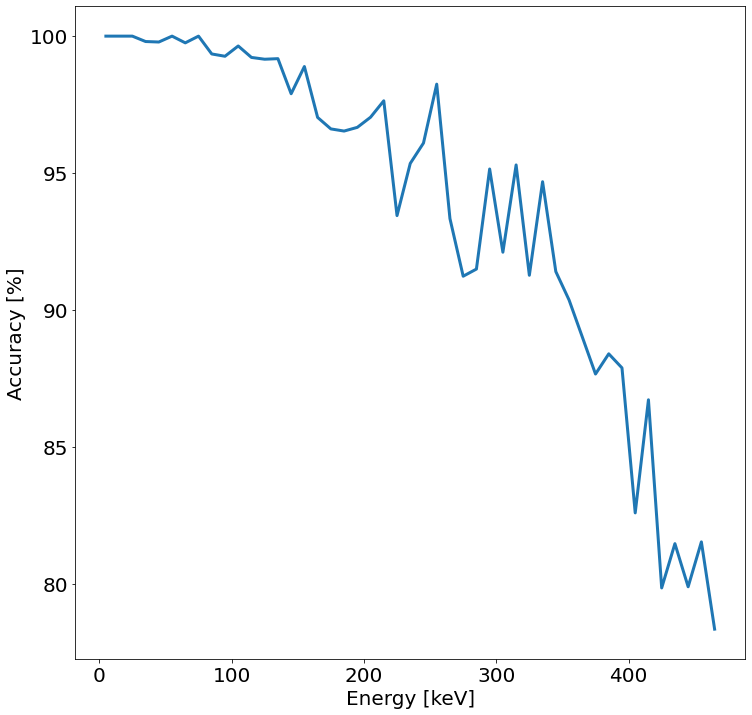

In [285]:
plt.figure(figsize=(12,12))
n_r,bins_r,patch = plt.hist(right,bins=np.arange(0,471,10),label='Right',histtype='step',lw=3)
n_w,bins_w,patch = plt.hist(wrong,bins=np.arange(0,471,10),label='Wrong',histtype='step',lw=3)
plt.legend(fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.figure(figsize=(12,12))
plt.plot((bins_r[:-1]+bins_r[1:])/2,n_r/(n_w+n_r)*100, lw=3)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [286]:
right = []
wrong = []

for i in range(len(test_labels)):
    test=test_data_noise[i].reshape(1,150,150,1)
    correct = test_labels[i] == round(model(test)[0][0].numpy())
    
    if correct:
        right.append(test_elabs[i])
    else:
        wrong.append(test_elabs[i])

In [287]:
len(right)/(len(right)+len(wrong))

0.5975609756097561

Testing on electron data

In [289]:
right = []
wrong = []

for i in range(len(e_stack)):
    test=e_stack[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy())
    
    if correct:
        right.append(1)
    else:
        wrong.append(2)

In [290]:
len(right)/(len(right)+len(wrong))

0.7352970846363361

In [84]:
#loading the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
train_dataset.element_spec

#printing relevant properties
for inputs, labs in train_dataset.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [85]:
#batching the datasets
batch_size = 50
train_dataset = train_dataset.batch(batch_size)  # drop_remainder=True
test_dataset = test_dataset.batch(batch_size)

In [87]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset, epochs=10, validation_data=(test_dataset))

Epoch 1/10
314/314 [==============================] - 19s 60ms/step - loss: 0.8132 - accuracy: 0.8471 - val_loss: 0.3242 - val_accuracy: 0.8572
Epoch 2/10
314/314 [==============================] - 19s 61ms/step - loss: 0.2491 - accuracy: 0.8789 - val_loss: 0.3052 - val_accuracy: 0.8613
Epoch 3/10
314/314 [==============================] - 19s 60ms/step - loss: 0.2248 - accuracy: 0.8892 - val_loss: 0.3075 - val_accuracy: 0.8577
Epoch 4/10
314/314 [==============================] - 19s 60ms/step - loss: 0.2088 - accuracy: 0.8944 - val_loss: 0.3142 - val_accuracy: 0.8610
Epoch 5/10
314/314 [==============================] - 19s 61ms/step - loss: 0.1960 - accuracy: 0.9035 - val_loss: 0.3243 - val_accuracy: 0.8633
Epoch 6/10
314/314 [==============================] - 19s 61ms/step - loss: 0.1868 - accuracy: 0.9077 - val_loss: 0.3394 - val_accuracy: 0.8623
Epoch 7/10
314/314 [==============================] - 19s 61ms/step - loss: 0.1747 - accuracy: 0.9154 - val_loss: 0.3767 - val_accuracy:

In [88]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset, epochs=10, validation_data=(test_dataset))

Epoch 1/10
314/314 [==============================] - 19s 60ms/step - loss: 0.1601 - accuracy: 0.9291 - val_loss: 0.4761 - val_accuracy: 0.8786
Epoch 2/10
314/314 [==============================] - 19s 61ms/step - loss: 0.1440 - accuracy: 0.9359 - val_loss: 0.4709 - val_accuracy: 0.8804
Epoch 3/10
314/314 [==============================] - 19s 60ms/step - loss: 0.1197 - accuracy: 0.9470 - val_loss: 0.4670 - val_accuracy: 0.8832
Epoch 4/10
314/314 [==============================] - 19s 60ms/step - loss: 0.1242 - accuracy: 0.9466 - val_loss: 0.4848 - val_accuracy: 0.8830
Epoch 5/10
314/314 [==============================] - 19s 61ms/step - loss: 0.1389 - accuracy: 0.9413 - val_loss: 0.4893 - val_accuracy: 0.8865
Epoch 6/10
314/314 [==============================] - 19s 60ms/step - loss: 0.1068 - accuracy: 0.9520 - val_loss: 0.6547 - val_accuracy: 0.8812
Epoch 7/10
314/314 [==============================] - 19s 61ms/step - loss: 0.0877 - accuracy: 0.9621 - val_loss: 0.7579 - val_accuracy:

In [89]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset, epochs=10, validation_data=(test_dataset))

Epoch 1/10
314/314 [==============================] - 20s 60ms/step - loss: 0.0927 - accuracy: 0.9651 - val_loss: 0.6913 - val_accuracy: 0.8939
Epoch 2/10
314/314 [==============================] - 19s 60ms/step - loss: 0.0616 - accuracy: 0.9748 - val_loss: 0.8993 - val_accuracy: 0.8878
Epoch 3/10
314/314 [==============================] - 19s 60ms/step - loss: 0.0509 - accuracy: 0.9788 - val_loss: 0.7355 - val_accuracy: 0.8858
Epoch 4/10
314/314 [==============================] - 19s 60ms/step - loss: 0.0501 - accuracy: 0.9800 - val_loss: 0.8250 - val_accuracy: 0.8865
Epoch 5/10
314/314 [==============================] - 19s 60ms/step - loss: 0.0574 - accuracy: 0.9801 - val_loss: 0.9019 - val_accuracy: 0.8840
Epoch 6/10
314/314 [==============================] - 19s 60ms/step - loss: 0.0551 - accuracy: 0.9788 - val_loss: 0.9064 - val_accuracy: 0.8860
Epoch 7/10
118/314 [==========>...................] - ETA: 10s - loss: 0.0492 - accuracy: 0.9792

KeyboardInterrupt: 

# Larger Conv net

In [124]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

# def mig_model():
#     mig_model = Sequential([
#         Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), activation='relu', padding='same'),
#         MaxPooling2D(),
#         Conv2D(25, kernel_size=(3,3), activation='relu', padding='same'),
#         MaxPooling2D(),
#         Conv2D(50, kernel_size=(3,3), activation='relu', padding='same'),
#         MaxPooling2D(),
#         Flatten(),
#         Dense(500, activation='relu'),
#         Dense(250, activation='relu'),
#         Dense(100, activation='relu'),
#         Dense(30, activation='relu'),
#         Dense(1, activation='sigmoid'),
#     ], name='mig_model')
#     return mig_model

# model = mig_model()

In [191]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
#         Dropout(0.1),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
#         Dropout(0.1),
        Flatten(),
        Dense(500),
        LeakyReLU(),
        Dense(100),
        LeakyReLU(),
        Dense(30),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

2022-09-01 12:53:01.321723: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-01 12:53:01.324480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-01 12:53:01.825727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 12:53:01.826053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:03.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-09-01 12:53:01.826100: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-01 12:53:01.830438: I tensorflow/stream_executor/platform/default/ds

In [192]:
model.summary()

Model: "mig_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 10)      100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 30)        2730      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 30)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41070)             0 

In [196]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(train_data_noise,axis=-1), train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((np.expand_dims(test_data_noise,axis=-1), test_labels))
train_dataset_noise.element_spec

#printing relevant properties
for inputs, labs in train_dataset_noise.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150, 1)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150, 1)
()


In [197]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)

In [198]:
model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=10, validation_data=(test_dataset_noise))

Epoch 1/10


2022-09-01 12:54:17.088391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-01 12:54:17.091346: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099995000 Hz
2022-09-01 12:54:17.167466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-01 12:54:17.388131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


473/473 [==============================] - 11s 21ms/step - loss: 929.1693 - accuracy: 0.6198 - val_loss: 8.2290 - val_accuracy: 0.7239
Epoch 2/10
473/473 [==============================] - 9s 19ms/step - loss: 3.7953 - accuracy: 0.7397 - val_loss: 8.5292 - val_accuracy: 0.3997
Epoch 3/10
473/473 [==============================] - 9s 19ms/step - loss: 53.9290 - accuracy: 0.7242 - val_loss: 5.6167 - val_accuracy: 0.4146
Epoch 4/10
473/473 [==============================] - 9s 19ms/step - loss: 4.7632 - accuracy: 0.7039 - val_loss: 1.7667 - val_accuracy: 0.7532
Epoch 5/10
473/473 [==============================] - 9s 19ms/step - loss: 1.6160 - accuracy: 0.7696 - val_loss: 1.3655 - val_accuracy: 0.7796
Epoch 6/10
473/473 [==============================] - 9s 19ms/step - loss: 1.3835 - accuracy: 0.7716 - val_loss: 0.6477 - val_accuracy: 0.8145
Epoch 7/10
473/473 [==============================] - 9s 19ms/step - loss: 0.5739 - accuracy: 0.8204 - val_loss: 1.7502 - val_accuracy: 0.7449
Epoch 

In [203]:
weights = model.layers[9].weights[0].numpy()
bias = model.layers[9].bias.numpy()


## Saving for Report

In [204]:
np.save('Figure_Data/fig8_weights1',weights)

Text(0.5, 0, 'bias')

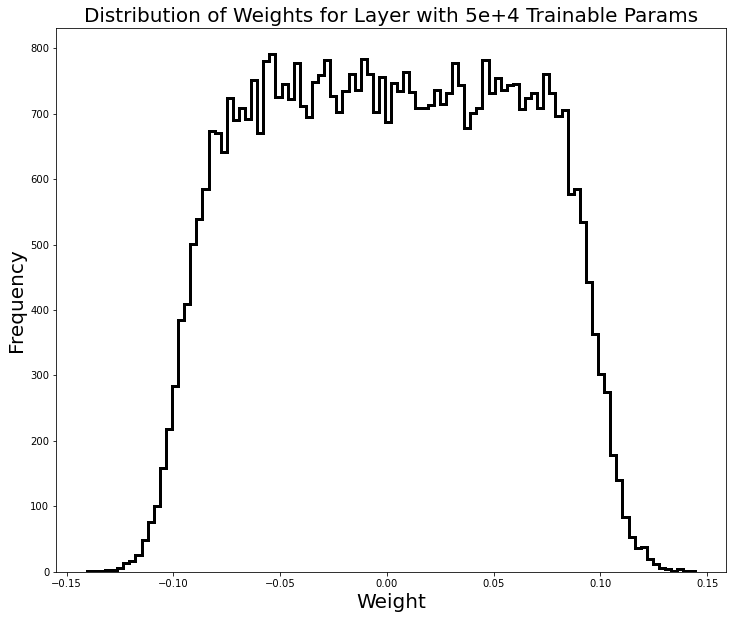

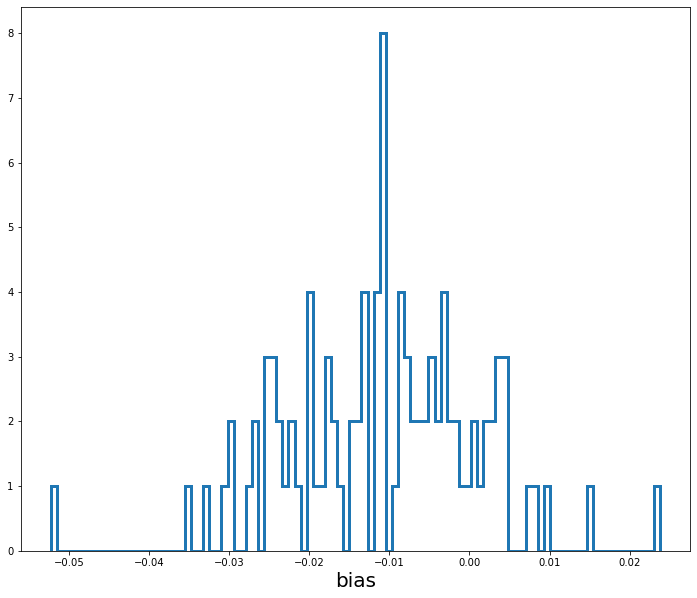

In [205]:
plt.figure(figsize=(12,10))
plt.hist(weights.flatten(),bins=100,histtype='step',lw=3,color='k')
plt.xlabel("Weight",fontsize=20)
plt.ylabel("Frequency",fontsize=20)
plt.title("Distribution of Weights for Layer with 5e+4 Trainable Params",fontsize=20)


plt.figure(figsize=(12,10))
plt.hist(bias.flatten(),bins=100,histtype='step',lw=3)
plt.xlabel("bias",fontsize=20)


In [206]:
weights = model.layers[7].weights[0].numpy()
bias = model.layers[7].bias.numpy()

In [207]:
np.save('Figure_Data/fig8_weights2',weights)

Text(0.5, 0, 'bias')

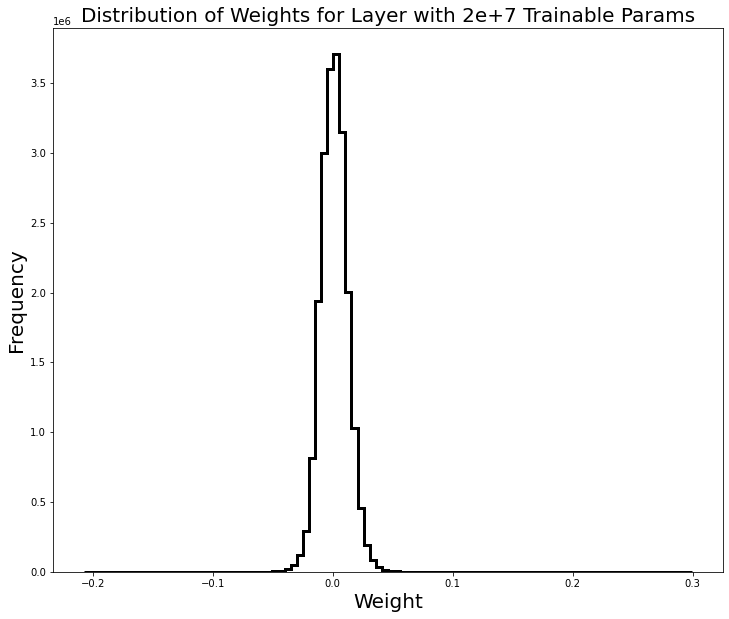

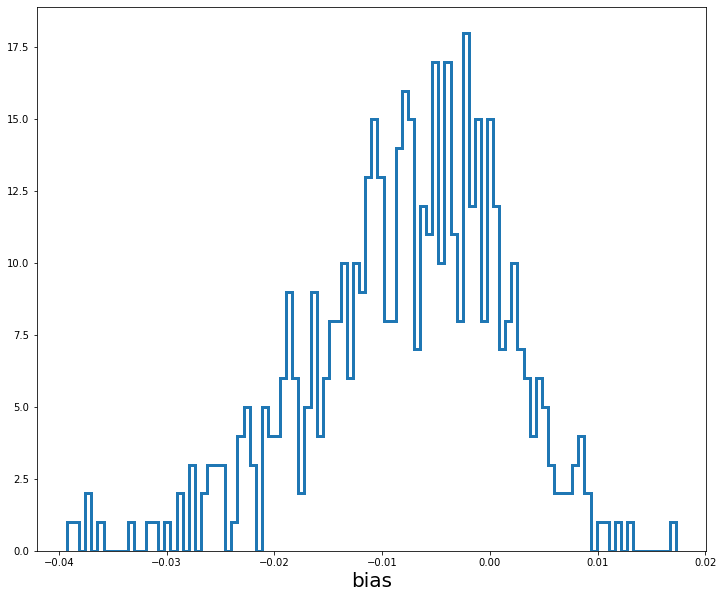

In [208]:
plt.figure(figsize=(12,10))
plt.hist(weights.flatten(),bins=100,histtype='step',lw=3,color='k')
plt.xlabel("Weight",fontsize=20)
plt.ylabel("Frequency",fontsize=20)
plt.title("Distribution of Weights for Layer with 2e+7 Trainable Params",fontsize=20)

plt.figure(figsize=(12,10))
plt.hist(bias.flatten(),bins=100,histtype='step',lw=3)
plt.xlabel("bias",fontsize=20)


## The datasets must be the same size

In [277]:
im_stack.shape

(9789, 150, 150)

In [278]:
e_stack.shape

(9913, 150, 150)

In [279]:
im_stack_plain.shape

(9815, 150, 150)

In [280]:
not_mig = np.concatenate([im_stack_plain,e_stack])
nm_elab = np.concatenate([energies_plain,5.9*np.ones(len(e_stack))])

In [281]:
not_mig.shape

(19728, 150, 150)

In [282]:
shuffle_index = np.arange(len(not_mig))
np.random.shuffle(shuffle_index)

not_mig_shuff = not_mig[shuffle_index]
nm_elab_shuff = nm_elab[shuffle_index]

new_not_mig = not_mig_shuff[:len(im_stack)]
new_nm_elab = nm_elab_shuff[:len(im_stack)]

In [283]:
print(im_stack.shape)
print(new_not_mig.shape)
print(new_nm_elab.shape)

(9789, 150, 150)
(9789, 150, 150)
(9789,)


In [284]:
energy_labels = np.concatenate([energies,new_nm_elab])
labels = np.concatenate([np.zeros_like(energies),np.ones_like(new_nm_elab)])
data = np.concatenate([im_stack,new_not_mig])

shuffle_index = np.arange(len(labels))
np.random.shuffle(shuffle_index)

energy_labels = energy_labels[shuffle_index]
labels = labels[shuffle_index]
data = data[shuffle_index]

In [285]:
train_data_noise, test_data_noise, train_labels, test_labels, train_elabs, test_elabs = \
train_test_split(data, labels, energy_labels, test_size=0.2, random_state=42)

In [286]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, Dropout

def mig_model():
    mig_model = Sequential([
        Conv2D(10, kernel_size=(3,3), input_shape=(150,150,1), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Conv2D(30, kernel_size=(3,3), padding='same'),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
#         Dropout(0.1),
        Dense(30),
        LeakyReLU(),
#         Dropout(0.1),
        Dense(15),
        LeakyReLU(),
        Dense(1, activation='sigmoid'),
    ], name='mig_model')
    return mig_model

model = mig_model()

In [287]:
#loading the data into tf.data.Dataset objects
train_dataset_noise = tf.data.Dataset.from_tensor_slices((train_data_noise, train_labels)) 
test_dataset_noise = tf.data.Dataset.from_tensor_slices((test_data_noise, test_labels))
migdal_dataset_noise = tf.data.Dataset.from_tensor_slices((im_stack, np.zeros_like(energies)))
train_dataset_noise.element_spec

#printing relevant properties
for inputs, labs in train_dataset_noise.take(2):
    print(type(inputs))
    print(type(labs))
    print(inputs.shape)
    print(labs.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 150)
()


In [288]:
#batching the datasets
batch_size = 50
train_dataset_noise = train_dataset_noise.batch(batch_size)  # drop_remainder=True
test_dataset_noise = test_dataset_noise.batch(batch_size)
migdal_dataset_noise = migdal_dataset_noise.batch(batch_size)

In [289]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10)

model = mig_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.fit(train_dataset_noise, epochs=50, validation_data=(test_dataset_noise),callbacks=[callback])

Epoch 1/50
314/314 [==============================] - 28s 88ms/step - loss: 4.4083 - accuracy: 0.6721 - val_loss: 1.1164 - val_accuracy: 0.6389
Epoch 2/50
314/314 [==============================] - 27s 87ms/step - loss: 0.6932 - accuracy: 0.7308 - val_loss: 0.6729 - val_accuracy: 0.7102
Epoch 3/50
314/314 [==============================] - 27s 87ms/step - loss: 0.5552 - accuracy: 0.7620 - val_loss: 0.5815 - val_accuracy: 0.7354
Epoch 4/50
314/314 [==============================] - 28s 89ms/step - loss: 0.4737 - accuracy: 0.7807 - val_loss: 0.5213 - val_accuracy: 0.7584
Epoch 5/50
314/314 [==============================] - 28s 88ms/step - loss: 0.4325 - accuracy: 0.7972 - val_loss: 0.4802 - val_accuracy: 0.7689
Epoch 6/50
314/314 [==============================] - 28s 88ms/step - loss: 0.4290 - accuracy: 0.7987 - val_loss: 0.4312 - val_accuracy: 0.7926
Epoch 7/50
314/314 [==============================] - 28s 88ms/step - loss: 0.3842 - accuracy: 0.8157 - val_loss: 0.4154 - val_accuracy:

In [290]:
right = []
wrong = []

for i in range(len(im_stack)):
    test=im_stack[i].reshape(1,150,150,1)
    correct = not round(model(test)[0][0].numpy())
    
    if correct:
        right.append(energies[i])
    else:
        wrong.append(energies[i]) 

In [291]:
len(right)/(len(right)+len(wrong))

0.8839513739912146

In [292]:
right = []
wrong = []

for i in range(len(im_stack_plain)):
    test=im_stack_plain[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy())
    
    if correct:
        right.append(1)
    else:
        wrong.append(2)
        
for i in range(len(e_stack)):
    test=e_stack[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy())
    
    if correct:
        right.append(1)
    else:
        wrong.append(2)

In [293]:
len(right)/(len(right)+len(wrong))

0.9217862935928629

In [294]:
right = []
wrong = []

for i in range(len(test_data_noise)):
    test=test_data_noise[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy()) == test_labels[i]
    
    if correct:
        right.append(test_elabs[i])
    else:
        wrong.append(test_elabs[i])

(array([ 60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

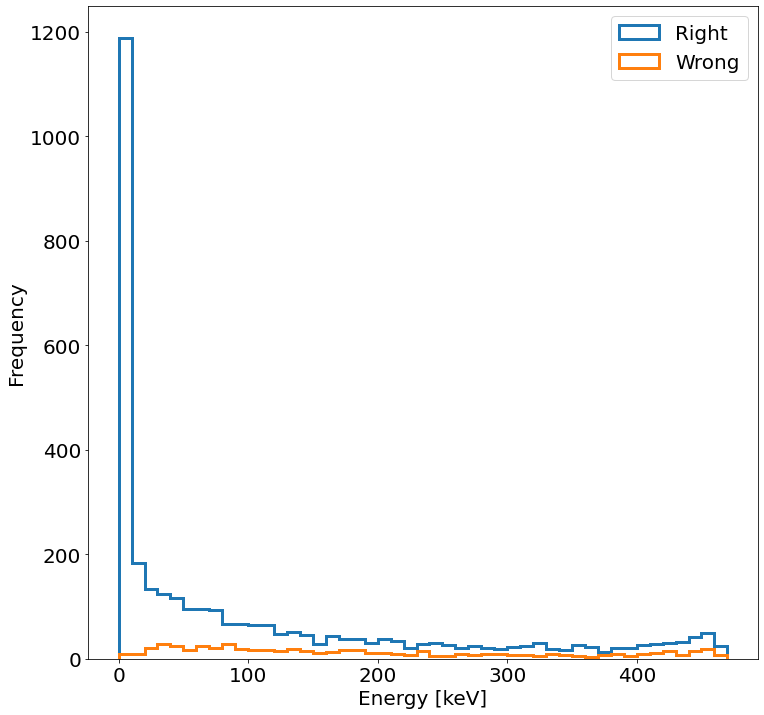

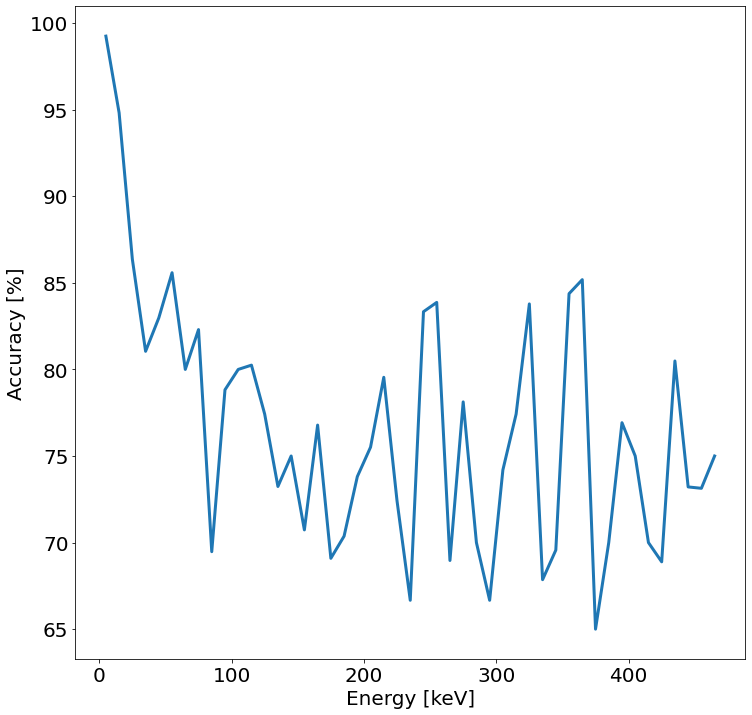

In [233]:
plt.figure(figsize=(12,12))
n_r,bins_r,patch = plt.hist(right,bins=np.arange(0,471,10),label='Right',histtype='step',lw=3)
n_w,bins_w,patch = plt.hist(wrong,bins=np.arange(0,471,10),label='Wrong',histtype='step',lw=3)
plt.legend(fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.figure(figsize=(12,12))
plt.plot((bins_r[:-1]+bins_r[1:])/2,n_r/(n_w+n_r)*100, lw=3)
plt.ylabel('Accuracy [%]',fontsize=20)
plt.xlabel('Energy [keV]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [223]:
right = []
wrong = []

for i in range(len(test_data_noise)):
    test=test_data_noise[i].reshape(1,150,150,1)
    correct = round(model(test)[0][0].numpy()) == test_labels[i]
    
    if correct:
        right.append(test_elabs[i])
    else:
        wrong.append(test_elabs[i])

In [224]:
len(right)/(len(right)+len(wrong))

0.849591419816139